## Stopword Identification

In order to create a custom stopword list which we feel will be sensible, we are going to isolate the 100 most common words across our entire dataset. Then, we will check if they are also in the top 100 most common words for each individual subreddit, and keep only those which are common for all three.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import matplotlib.pyplot as plt
import seaborn as sns
import json

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('../data/preprocessed_subreddit_data.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
df['fulltext'] = df['title'] + ' ' + df['selftext']

In [5]:
freefolk = df[df['subreddit']=='freefolk']
gameofthrones = df[df['subreddit']=='gameofthrones']
asoiaf = df[df['subreddit']=='asoiaf']

In [6]:
df['subreddit'].value_counts(normalize=True)

asoiaf           0.443182
freefolk         0.283519
gameofthrones    0.273299
Name: subreddit, dtype: float64

In [7]:
df_vec = CountVectorizer(stop_words='english',
                        max_df=.325,
                        max_features = 6500,
                        min_df = 5,
                        ngram_range = (1,2))

df_tab = df_vec.fit_transform(df['fulltext'])
df_pd = pd.DataFrame(df_tab.toarray(), columns=df_vec.get_feature_names())

In [8]:
ff_vec = CountVectorizer(stop_words='english',
                        max_df=.325,
                        max_features = 6500,
                        min_df = 5,
                        ngram_range = (1,2))
ff_tab = ff_vec.fit_transform(freefolk['fulltext'])
ff_pd = pd.DataFrame(ff_tab.toarray(), columns=ff_vec.get_feature_names())

In [9]:
got_vec = CountVectorizer(stop_words='english',
                        max_df=.325,
                        max_features = 6500,
                        min_df = 5,
                        ngram_range = (1,2))

got_tab = got_vec.fit_transform(gameofthrones['fulltext'])
got_pd = pd.DataFrame(got_tab.toarray(), columns=got_vec.get_feature_names())

In [10]:
asoiaf_vec = CountVectorizer(stop_words='english',
                        max_df=.325,
                        max_features = 6500,
                        min_df = 5,
                        ngram_range = (1,2))

asoiaf_tab = asoiaf_vec.fit_transform(asoiaf['fulltext'])
asoiaf_pd = pd.DataFrame(asoiaf_tab.toarray(), columns=asoiaf_vec.get_feature_names())

We are going to take the 100 most common words overall and in each subreddit and find only the words which are top 100 most common for all three subreddits common to add to our stopwords list:

In [11]:
most_common_overall = df_pd.mean().sort_values(ascending=False)[0:100]

most_common_ff = ff_pd.mean().sort_values(ascending=False)[0:100]

most_common_got = got_pd.mean().sort_values(ascending=False)[0:100]

most_common_asoiaf = asoiaf_pd.mean().sort_values(ascending=False)[0:100]

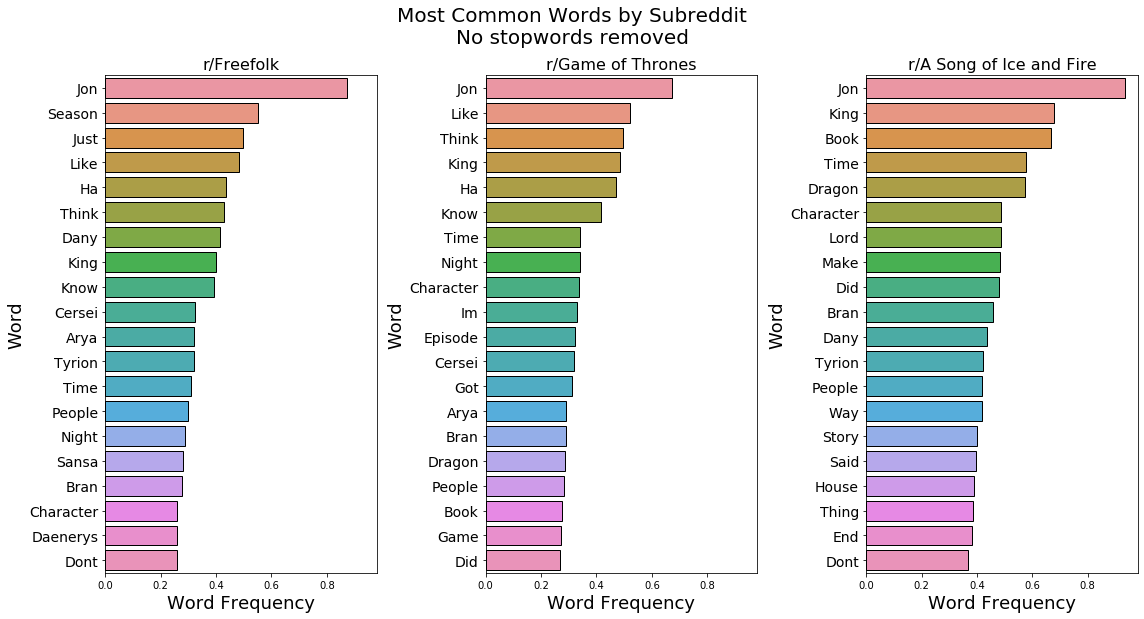

In [26]:
tables = [most_common_ff,most_common_got,most_common_asoiaf]
titles = ['r/Freefolk','r/Game of Thrones','r/A Song of Ice and Fire']

fig, ax = plt.subplots(1,3, sharex=True, figsize=(16,8))
axs = ax.ravel()
fig.suptitle('Most Common Words by Subreddit\nNo stopwords removed', fontsize=20, y=1.07)
for i, ax in enumerate(axs):
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel('Word Frequency', fontsize=18)
    ax.set_ylabel('Word', fontsize=18)
    sns.barplot(tables[i][0:20],tables[i].index.str.title()[0:20], orient='h',ax=ax, ec='k', linewidth=1)
fig.tight_layout()

As you can see, there is extreme overlap in the most common words of each subreddit due to their shared subject matter. Despite r/asoiaf being a (mostly) book-focused discussion subreddit, the major characters (such as Jon and Dany/Danaerys) and topics (kings, dragons, etc.) are shared by both the books and television show.

In order to see the actually interesting patterns in our posts, we need to remove the most common *shared* words, so that we can see what actually sets them apart.

In [13]:
common_ff = most_common_ff[~(most_common_ff - most_common_overall).isna()]

common_got = most_common_got[~(most_common_got - most_common_overall).isna()]

common_asoiaf = most_common_asoiaf[~(most_common_asoiaf - most_common_overall).isna()]

In [14]:
a =common_ff[~(common_ff - common_got).isna()]

b=common_ff[~(common_ff - common_asoiaf).isna()]

c=common_asoiaf[~(common_asoiaf - common_got).isna()]

d=common_asoiaf[~(common_asoiaf - common_ff).isna()]

e=common_got[~(common_got - common_ff).isna()]

f=common_got[~(common_got - common_asoiaf).isna()]

In [15]:
custom_stopwords = list((a+b+c+d+e+f).index)
len(custom_stopwords)

86

There are a few additional stopwords that we would like to add based on context. In particular, r/asoiaf titles are required to have spoiler tags. Passing these spoiler tags to our models would be cheating, as this is a format only seen on one of our subreddits and has nothing to do with the content of the posts.

Also, for some reason the word `just` has escaped our filtering, so we will remove that as well.

In [16]:
custom_stopwords += ['spoiler','spoilers','extended','main','just','thats','infinite']

In [17]:
custom_stopwords

['army',
 'arya',
 'battle',
 'believe',
 'book',
 'bran',
 'cersei',
 'character',
 'child',
 'come',
 'daenerys',
 'dany',
 'dead',
 'death',
 'did',
 'didnt',
 'doe',
 'doesnt',
 'dont',
 'dragon',
 'end',
 'episode',
 'game',
 'going',
 'good',
 'got',
 'great',
 'ha',
 'hand',
 'house',
 'im',
 'jaime',
 'jon',
 'kill',
 'king',
 'kings',
 'know',
 'lannister',
 'life',
 'like',
 'long',
 'look',
 'lord',
 'love',
 'make',
 'man',
 'maybe',
 'mean',
 'men',
 'ned',
 'need',
 'night',
 'night king',
 'north',
 'people',
 'point',
 'really',
 'right',
 'said',
 'sansa',
 'say',
 'scene',
 'season',
 'series',
 'snow',
 'stark',
 'story',
 'sword',
 'targaryen',
 'tell',
 'theory',
 'thing',
 'think',
 'thought',
 'throne',
 'time',
 'tyrion',
 'wall',
 'want',
 'war',
 'watch',
 'way',
 'westeros',
 'white',
 'winterfell',
 'year',
 'spoiler',
 'spoilers',
 'extended',
 'main',
 'just',
 'thats']

In [18]:
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stopwords))

In [19]:
stop_words = {'words':stop_words}

In [20]:
with open('../data/stop_words.json', 'w') as fp:
    json.dump(stop_words, fp)